# Relatedness and Population Structure

In [1]:
using Distributions
using DataFrames
using MultivariateStats
using Plots, Measures, StatsPlots
using CSV, HTTP
using Printf

# Default plot settings
gr(html_output_format=:png) # Avoid SVG and force PNG format for plots

Plots.GRBackend()

### Utility functions
Some of these may have an efficient implementation in other packages, but for keeping
things simple and complete, a crude implementation is given here.

In [2]:
# scale() function of R
scale_data(d::AbstractArray; dims=1) = (d .- mean(d, dims=dims)) ./ std(d, dims=dims)

scale_data (generic function with 1 method)

## 5.1 Genetic Relatedness

### 5.1.2 Estimating relatedness

##### Example 5.1

In [3]:
"""
    offspring_geno(n_families, n_snps, fs, n_shared_parents=2)

Generating pairs of offspring that share `n_shared_parents` number of parents

# Arguments
- `n_families::Integer`: number of families where each family produces two offspring (>0)
- `n_snps::Integer`: number of independent SNPs used in simulation (>0)
- `fs::Vector{Float64}`: vector of allele 1 frequencies for SNPs, length == n_snps, values > 0 & < 1
- `n_shared_parents::Integer`: 0, 1, 2 shared parents for two offspring in each family

# Returns
- `X::Matrix{Integer}`: the genotpe of 2xn_families offspring, (2xn_families) x n_snps matrix with 0, 1, 2 entries
"""
function offspring_geno(n_families, n_snps; fs=nothing, n_shared_parents=2)
    n_families > 0 || throw(DomainError("`n_families` must be > 0"))
    n_snps > 0 || throw(DomainError("`n_snps` must be > 0"))
    
    if fs == nothing
        fs = fill(0.50, n_snps)
    else
        length(fs) == n_snps || throw(DomainError("`fs` must have length = `n_snps`"))
        all(0.0 .< fs .< 1.0) || throw(DomainError("Values of `fs` must be in (0.00, 1.00)"))
    end
    
    n_shared_parents ∈ 0:2 || throw(DomainError("`n_shared_parents` must be in {0, 1, 2}")) 

    if n_shared_parents == 2
        parents = [ [1, 2], [ 1, 2]]
    elseif n_shared_parents == 1
        parents = [ [1, 2], [ 3, 2]]
    else # must be 0
        parents = [ [1, 2], [ 3, 4]]
    end
    n_parents = 4 - n_shared_parents
    
    X = fill(0, 2n_families, n_snps)
    for ii ∈ 1:n_families
        x_parents = reduce(hcat, rand.(Binomial.(1, fs), 2*n_parents))
        for offs ∈ 1:2 # for two offsprings within family
            # phase is the indicator of whether offs inherit each parents' 1st allele or not
            phase = rand(2, n_snps) .> 0.50
            for i_parent ∈ 1:2
                for ph ∈ 0:1
                    loci = phase[i_parent, :] .== ph # which loci from i_parent have phase ph?
                    # add to current offs' genotype i_parent's allele from correct phase
                    X[2*(ii-1) + offs, loci] = X[2*(ii-1) + offs, loci] +
                        x_parents[2*parents[offs][i_parent] - ph, loci]
                end
            end
        end
    end
    
    return X
end

offspring_geno

In [4]:
p = 10000 # SNPs
fs = rand(p) .* 0.30 .+ 0.20 # MAF at each SNP is Uniform(0.2, 0.5)

X = reduce(vcat, offspring_geno(5, p, fs=fs, n_shared_parents=n) for n ∈ 0:2)

X = X[:, vec(mapslices(var, X, dims=1) .> 0)]; # remove possible monomorphic variants (SNP sites which have only single value)

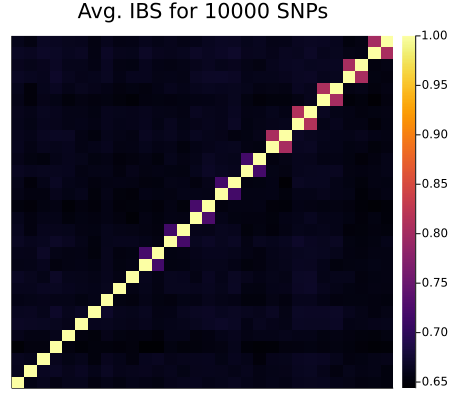

In [5]:
n_cols = 50 # number of colors
IBS_2 = ((X.==2) * (X.==2)' .+ (X.==1) * (X.==1)' .+ (X.==0) * (X.==0)') / p;
IBS_1 = ((X.==1) * ((X.==0) .| (X.==2))' .+ (X.==1) * ((X.==0) .| (X.==2))') / p
IBS = @. IBS_2 + 0.50 * IBS_1
heatmap(IBS, size=(450, 400), title="Avg. IBS for 10000 SNPs", 
        xaxis=nothing, yaxis=nothing)

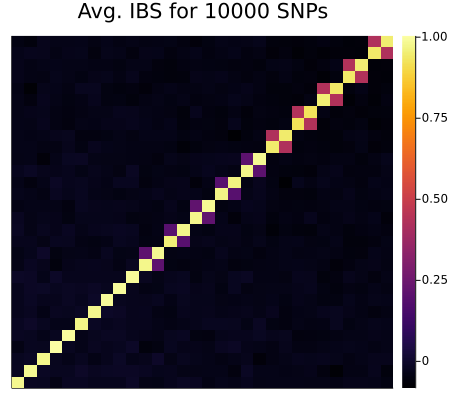

In [6]:
X_scaled = scale_data(X) # standardize each SNP at columns of X
GRM = (X_scaled * X_scaled') ./ p # correlation matrix of individuals based on standadized SNPs

heatmap(GRM, size=(450, 400), title="Avg. IBS for 10000 SNPs",
        xaxis=nothing, yaxis=nothing)

In [7]:
full_sibs = findall(grm -> 0.40 < grm < 0.60, GRM)
full_sibs = filter(x -> x.I[1] < x.I[2], full_sibs)
reduce(vcat, [[x.I[1], x.I[2]] for x ∈ full_sibs])

10-element Vector{Int64}:
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30

In [8]:
half_sibs = findall(grm -> 0.15 < grm < 0.35, GRM)
half_sibs = filter(x -> x.I[1] < x.I[2], half_sibs)
reduce(vcat, [[x.I[1], x.I[2]] for x ∈ half_sibs])

10-element Vector{Int64}:
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20

##### KING

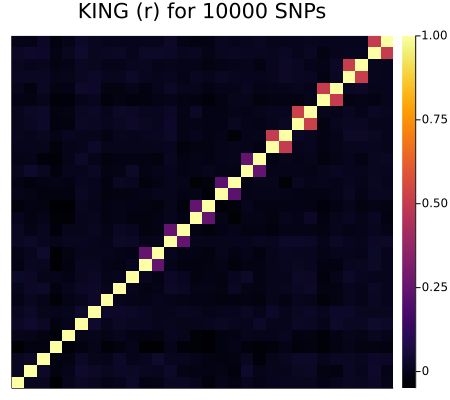

In [9]:
denominator = repeat(sum(X.==1, dims=2)', size(X, 1), 1) .+ repeat(sum(X.==1, dims=2), 1, size(X, 1))
king_r = 2 * ((X.==1) * (X.==1)' .- 2 * ((X.==0) * (X.==2)' + (X.==2) * (X.==0)')) ./ denominator

heatmap(king_r, size=(450, 400), title="KING (r) for 10000 SNPs",
        xaxis=nothing, yaxis=nothing)

## 5.2 Population Structure

### 5.2.1 Sources of population structure

##### Example 5.2: Genetic Drift

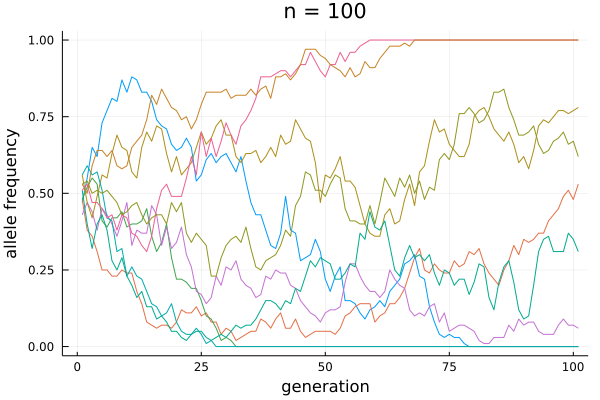

In [10]:
n = 100 # alleles in each generation of each population
f0 = 0.50  # starting allele frequency
K = 100 # number of generations in simulation
npop = 10 # Let's make 10 rather than just 2 pops to illustrate more general behavior
f = Matrix{Float64}(undef, npop, K+1) # results of allele freqs across pops and generation
for pop ∈ 1:npop
    a = rand(n) .< f0 # starting configuration of alleles
    f[pop, 1] = mean(a) # allele frequency at generation 0
    for ii ∈ 1:K
        a = rand(a, n) # resample generation ii
        f[pop, ii+1] = mean(a) # allele frequency at generation
    end
end

plot(f', label=nothing, title=@sprintf("n = %d", n),
     ylabel="allele frequency", xlabel="generation",
     xlims=[0, K], ylims=[0.0, 1.0])

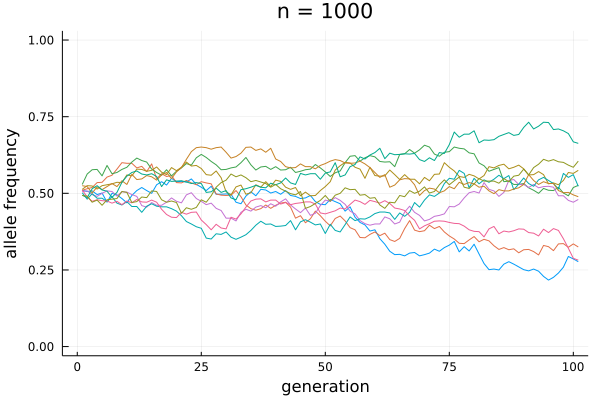

In [11]:
n = 1000 # alleles in each generation of each population
f0 = 0.50  # starting allele frequency
K = 100 # number of generations in simulation
npop = 10 # Let's make 10 rather than just 2 pops to illustrate more general behavior
f = Matrix{Float64}(undef, npop, K+1) # results of allele freqs across pops and generation
for pop ∈ 1:npop
    a = rand(n) .< f0 # starting configuration of alleles
    f[pop, 1] = mean(a) # allele frequency at generation 0
    for ii ∈ 1:K
        a = rand(a, n) # resample generation ii
        f[pop, ii+1] = mean(a) # allele frequency at generation
    end
end

plot(f', label=nothing, title=@sprintf("n = %d", n),
     ylabel="allele frequency", xlabel="generation",
     xlims=[0, K], ylims=[0.0, 1.0])

### 5.2.2 Principal component analysis (PCA)

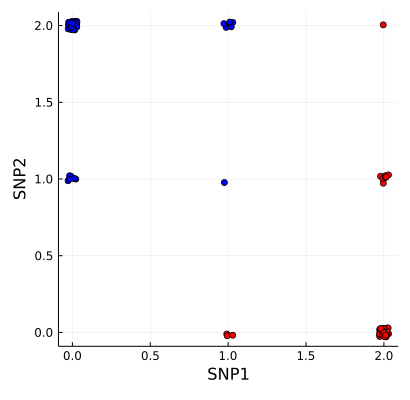

In [12]:
npop = 2
cols = ["blue", "red"]
f = [0.05 0.95; 0.95 0.05]
p = size(f, 2) # number of SNPs
n = fill(50, npop) # number of sample from each popluation
pop = repeat(1:npop, inner=n)
X = reduce(hcat,
    [
        reduce(vcat, [rand(Binomial(2, f[ii, jj]), n[jj]) for jj ∈ 1:npop])
        for ii ∈ 1:p
    ]
)
jitt_1 = rand(size(X, 1)) * 0.06 .- 0.03
jitt_2 = rand(size(X, 1)) * 0.06 .- 0.03
scatter(X[:, 1] .+ jitt_1, X[:, 2] .+ jitt_2, c=cols[pop],
    xlabel="SNP1", ylabel="SNP2", label=nothing, size=(410, 400))

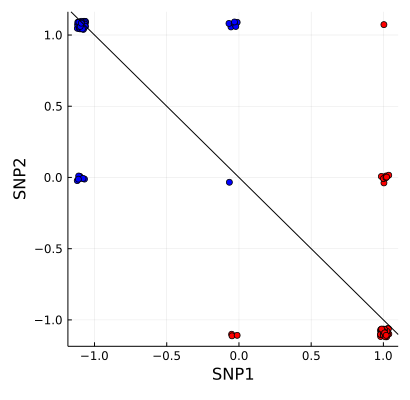

In [13]:
X = scale_data(X) # always standardize each variant before PCA
pca = fit(PCA, X', maxoutdim=1) # we are interested in only one output dimension
prj = projection(pca)
scatter(X[:, 1] .+ jitt_1, X[:, 2] .+ jitt_2, c=cols[pop],
    xlabel="SNP1", ylabel="SNP2", label=nothing, size=(410, 400))
Plots.abline!(prj[2, 1]/prj[1, 1], 0, label=nothing, c="black")

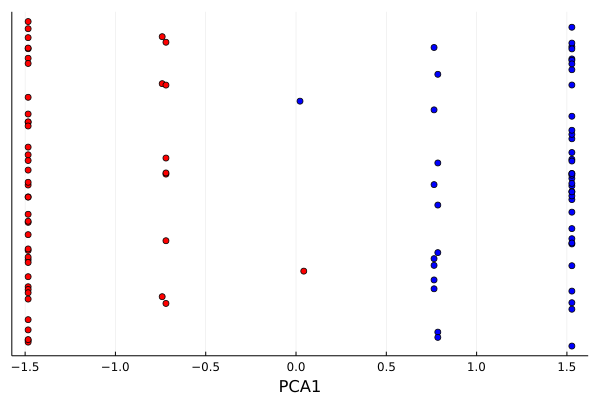

In [14]:
scatter(
    vec(MultivariateStats.transform(pca, X')), rand(100),
    c=cols[pop], label=nothing, yaxis=nothing, xlabel="PCA1"
)

##### Example 5.3

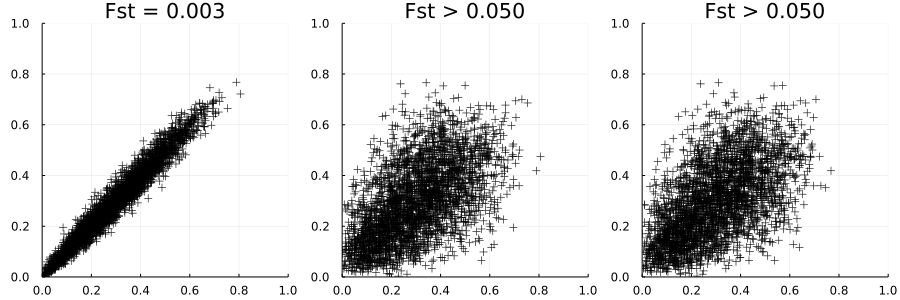

In [15]:
n = 100 # per population
p = 3000 # SNPs
fst_12 = 0.003
fst_12_3 = 0.05
f = rand(p) * 0.40 .+ 0.10 # common SNPs in background
f_3 = rand.(Beta.((1 - fst_12_3) / fst_12_3 * f, (1 - fst_12_3) / fst_12_3 * (1 .- f)))
f_12 = rand.(Beta.((1 - fst_12_3) / fst_12_3  * f, (1 - fst_12_3) / fst_12_3 .* (1 .- f))) # P1 and P2's shared ancestor
f_1 = rand.(Beta.((1 - fst_12) / fst_12 .* f_12, (1 - fst_12) / fst_12 .* (1 .- f_12)))
f_2 = rand.(Beta.((1 - fst_12) / fst_12 .* f_12, (1 - fst_12) / fst_12 .* (1 .- f_12)))

# Let's check that f1 and f2 looks similar compared to f_1 and f_3 or f_2 and f_3
fig = plot(layout=(1, 3), size=(900, 300))
scatter!(fig, subplot=1, f_1, f_2, 
    marker=:cross, markercolor=:black,
    xlim=(0, 1), ylim=(0, 1),
    label=nothing, title=@sprintf("Fst = %.3f", fst_12)
)
scatter!(fig, subplot=2, f_1, f_3,
    marker=:cross, markercolor=:black,
    xlim=(0, 1), ylim=(0, 1),
    label=nothing, title=@sprintf("Fst > %.3f", fst_12_3)
)
scatter!(fig, subplot=3, f_2, f_3,
    marker=:cross, markercolor=:black,
    xlim=(0, 1), ylim=(0, 1),
    label=nothing, title=@sprintf("Fst > %.3f", fst_12_3)
)

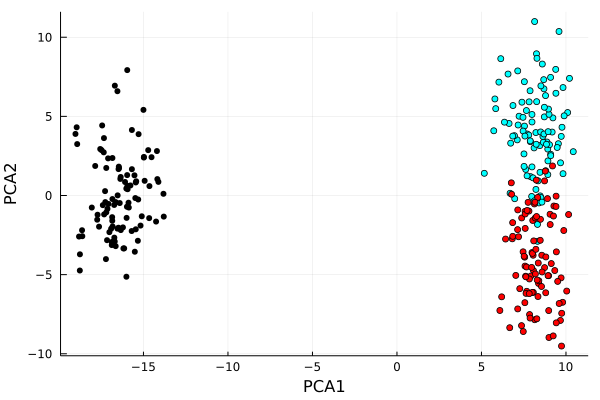

In [16]:
x = vcat(
    reduce(hcat, rand.(Binomial.(2, f_1), n)),
    reduce(hcat, rand.(Binomial.(2, f_2), n)),
    reduce(hcat, rand.(Binomial.(2, f_3), n))
)
x = scale_data(x)
pca = fit(PCA, x', maxoutdim=2)
cols = repeat(["cyan", "red", "black"], inner=n) # color for each individual according to population
proj = MultivariateStats.transform(pca, x')
scatter(proj[1, :], proj[2, :], c=cols, xlabel="PCA1", ylabel="PCA2", label=nothing)

##### Example 5.4

In [17]:
data_url = "https://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/afreq_1000G_phase1_chr15-22.txt"
af = CSV.File(HTTP.get(data_url).body) |> DataFrame
size(af)

(5266, 19)

In [18]:
ENV["COLUMNS"]=200 # To display all columns in data
af[1, :]

,chr,id,position,a0,a1,ASW,CEU,CHB,CHS,CLM,FIN,GBR,IBS,JPT,LWK,MXL,PUR,TSI,YRI
,Int64,String,Int64,String,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,15,rs11248847,20101049,G,A,0.2377,0.1882,0.4278,0.335,0.1917,0.1613,0.1461,0.2143,0.3876,0.2165,0.25,0.2091,0.1888,0.09659


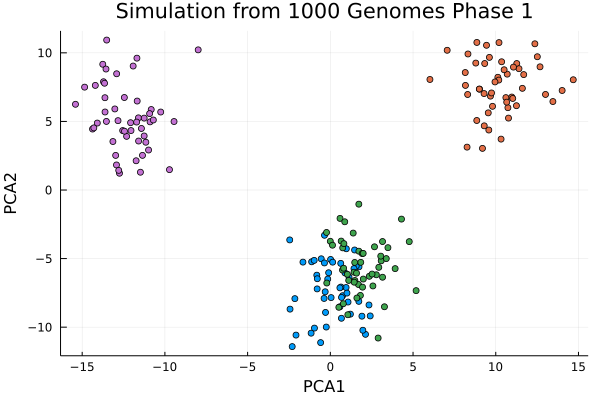

In [19]:
p = size(af, 2) # number of SNPs
n = 50 # samples per population
pop_labs = ["GBR", "TSI", "CEU", "FIN"]
pop = repeat(1:length(pop_labs), inner=n)

x = reduce(
    vcat, [
        reduce(hcat, rand.(Binomial.(2, af[!, _pop_lab]), n)) 
        for _pop_lab ∈ pop_labs
    ]
)
x = x[:, vec(mapslices(var, x, dims=1) .> 0)]; # remove possible monomorphic variants (SNP sites which have only single value)
x = scale_data(x)

pca = fit(PCA, x', maxoutdim=3)
prj = MultivariateStats.transform(pca, x')
scatter(prj[1, :], prj[2, :], c=pop, xlabel="PCA1", ylabel="PCA2", label=nothing,
        title="Simulation from 1000 Genomes Phase 1")

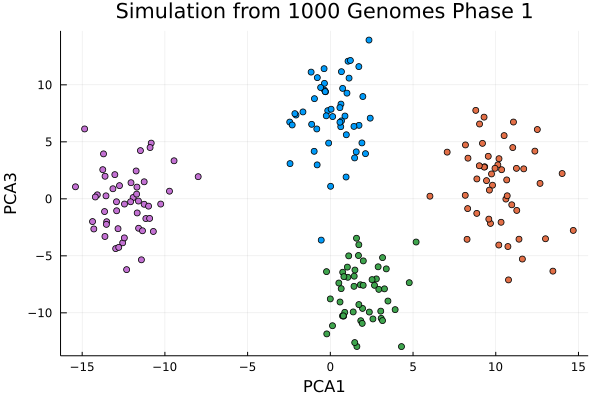

In [20]:
scatter(prj[1, :], prj[3, :], c=pop, 
    xlabel="PCA1", ylabel="PCA3", label=nothing,
    title="Simulation from 1000 Genomes Phase 1"
)

##### Example 5.5

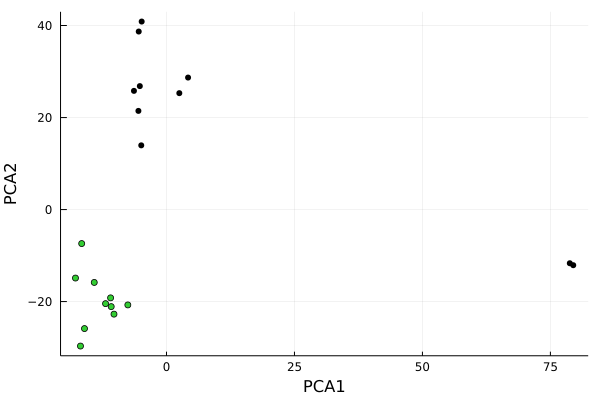

In [21]:
p = 10000 # SNPs
fst_12 = 0.01
cols = ["black", "limegreen"]
f = rand(p) * 0.30 .+ 0.20 # common SNPs in background population
f_1 = rand.(Beta.((1 - fst_12) / fst_12 * f, (1 - fst_12) / fst_12 * (1 .- f)))
f_2 = rand.(Beta.((1 - fst_12) / fst_12 * f, (1 - fst_12) / fst_12 * (1 .- f)))

X = vcat(
    offspring_geno(1, p, fs=f_1, n_shared_parents=2), # full sibs from 1
    offspring_geno(4, p, fs=f_1, n_shared_parents=0), # unrel from 1
    offspring_geno(5, p, fs=f_2, n_shared_parents=0), # unrel from 2
)
pop = repeat(1:2, inner=2*5)

X = X[:, vec(mapslices(var, X, dims=1) .> 0)]
X = scale_data(X)
pca = fit(PCA, X', maxoutdim=2)
prj = MultivariateStats.transform(pca, X')
scatter(prj[1, :], prj[2, :], c=cols[pop], 
    xlabel="PCA1", ylabel="PCA2", label=nothing
)

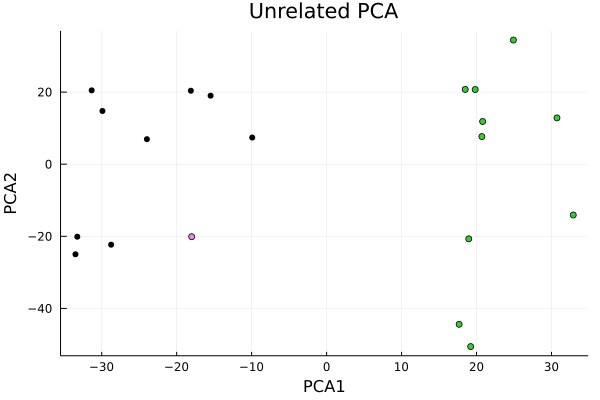

In [22]:
X_unrel = X[2:end, :]
pca = fit(PCA, X_unrel', maxoutdim=2)
prj = MultivariateStats.transform(pca, X_unrel')
scatter(prj[1, :], prj[2, :], c=cols[pop[2:end]],
    xlabel="PCA1", ylabel="PCA2", label=nothing,
    title="Unrelated PCA"
)
prj1 = MultivariateStats.transform(pca, X[1,:])
scatter!(prj1[1, :], prj[2, :], c="violet", label=nothing)

### 5.2.3 Relatedness estimation with population structure

In [23]:
p = 10000 # SNPs
fst_12 = 0.1
f = rand(p) * 0.30 .+ 0.20 # common SNPs in background
f_1 = rand.(Beta.((1 - fst_12) / fst_12 * f, (1 - fst_12) / fst_12 * (1 .- f)))
f_2 = rand.(Beta.((1 - fst_12) / fst_12 * f, (1 - fst_12) / fst_12 * (1 .- f)))

X = vcat(
    offspring_geno(4, p, fs=f_1, n_shared_parents=1),
    offspring_geno(1, p, fs=f_2, n_shared_parents=1)
)

X = X[:, vec(mapslices(var, X, dims=1)) .> 0]

# make GRM R
X_scaled = scale_data(X) # standardize each SNP at columns of X
GRM = (X_scaled * X_scaled') ./ p
    
# make KING-robust estimate
denominator = repeat(sum(X.==1, dims=2)', size(X, 1), 1) .+ repeat(sum(X.==1, dims=2), 1, size(X, 1))
king_r = 2 * ((X.==1) * (X.==1)' .- 2 * ((X.==0) * (X.==2)' + (X.==2) * (X.==0)')) ./ denominator;

[0.10540023144012045, 0.09260310924476448, 0.10819409081586741, 0.10294563781703064, 0.289756803570977]

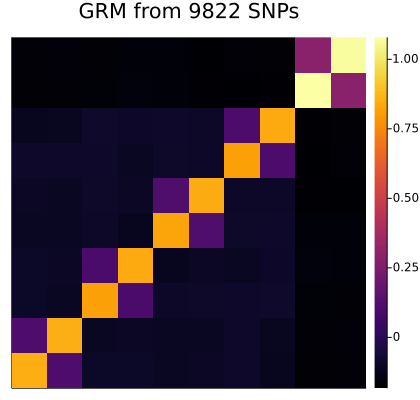

In [24]:
n_cols = 5 # make 5 categories of relatives
brk = [-1, 0.088, 0.177, 0.354, 0.707, 1.5] # KING's breakpoints for unrelated, 3rd, 2nd, 1st, monozygotes
labs = ["unrel", "3rd", "2nd", "1st", "same"]

print([GRM[1, 2], GRM[3, 4], GRM[5, 6], GRM[7, 8], GRM[9, 10]])

heatmap(GRM, size=(420, 400), 
    xticks=nothing, yticks=nothing, 
    title=@sprintf("GRM from %d SNPs", size(X, 2))
)

[0.26262880120633325, 0.24378488077118213, 0.2657325159514575, 0.26287744227353466, 0.22270630445925166]

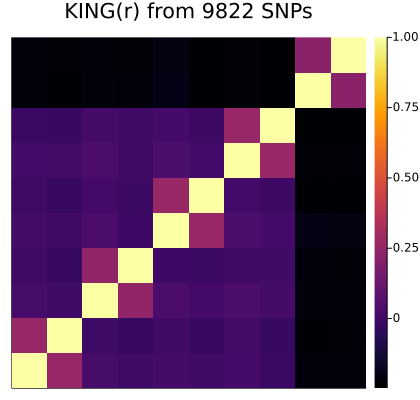

In [25]:
n_cols = 5 # make 5 categories of relatives
brk = [-1, 0.088, 0.177, 0.354, 0.707, 1.5] # KING's breakpoints for unrelated, 3rd, 2nd, 1st, monozygotes
labs = ["unrel", "3rd", "2nd", "1st", "same"]

print([king_r[1, 2], king_r[3, 4], king_r[5, 6], king_r[7, 8], king_r[9, 10]])

heatmap(king_r, size=(420, 400), 
    xticks=nothing, yticks=nothing, 
    title=@sprintf("KING(r) from %d SNPs", size(X, 2))
)